# ADM-HW2

## Group 9:
### Nazanin Bagherinejad {RQ1, RQ4, CRQ1}, Antonio  Furnari{RQ3}, Meher Kavya Koppisetti{-}  

### RQ1 :
#### Who wants to be a Champion? During a season could happen that a team has bad periods. For example, more than three consecutive games lost, or it could have a positive trend where it seems to be unbeatable. Let's visualize this trends!

#### Create a plot where each point (x,y) represents the number of points obtained by team x at game week y. In order to show the trends, points related to the same team must be connected to each other. Remind: in soccer each team gets 3 points for a win, 1 point for a tied game, and 0 for a loss. Highlight the two teams that got the longest winning streak (# of consecutive wins), and the two teams that got the longest losing streak (# of consecutive losses).

#### Below you can see a similar example of what we would like you to show us. Keep in mind that you must create this plot for all the entire season (38 game weeks).

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [47]:
#import json files as pandas DataFrames
teams = pd.read_json("DATA/teams.json")
matches = pd.read_json("DATA/Matches/matches_england.json")

In [48]:
area_names = teams.area.dropna().apply(pd.Series).name #extract the area names from area column
#drop the area column and assign a new column "areaName"
clean_teams = teams.drop('area', 1).assign(**pd.DataFrame(np.array(area_names.tolist()), columns=['areaName']))

In [49]:
# specify the countries we're not interested in
# one team from Wales is also in Premier League
dropRows = set(clean_teams.areaName) - {'England', 'Wales'} 
# drop all the rows with that areaNames and only keep the one we were looking for...
clean_teams.drop(clean_teams[clean_teams.areaName.str.contains('|'.join(dropRows))].index, inplace = True)
# drop the national team(if exist) and keep the clubs...
clean_teams.drop(clean_teams[clean_teams.type.str.contains('national')].index, inplace = True)

In [50]:
#drop columns from teams which we dont need anymore
clean_teams.drop(columns = ['city', 'areaName', 'type', 'officialName'], inplace = True)
#drop the columns from matches that we dont need
matches.drop(columns = ['competitionId', 'date', 'dateutc', 'duration', 'label', 'referees', 
                                         'roundId', 'seasonId', 'status', 'venue', 'wyId'], inplace = True )

In [51]:
# Extract the team ids from teamData
team_ids = [list(matches['teamsData'].values[i].keys()) for i in range(len(matches['teamsData']))]
#drop the teamData column and assign two new columns for each team
clean_matches = matches.drop('teamsData', 1).assign(**pd.DataFrame(np.array(team_ids), columns = ['team1', 'team2']))

In [52]:
clean_matches['team1']=clean_matches['team1'].astype(int)
#join the dataFrames to get team1's name
final_ds = pd.merge(clean_matches, clean_teams, left_on='team1', right_on='wyId')

In [53]:
final_ds.rename(columns = {"name": "team1Name"}, inplace = True)
final_ds.drop(columns = ['wyId'], inplace = True) #get rid of repeated data

In [54]:
final_ds['team2']=final_ds['team2'].astype(int)
#join the dataFrames again to get team2's name
final = pd.merge(final_ds, clean_teams, left_on='team2', right_on='wyId')

In [55]:
final.rename(columns = {"name": "team2Name"}, inplace = True)
final.drop(columns = ['wyId'], inplace = True) #get rid of repeated data

In [80]:
weeks_points = [] #2D array to store each teams points for each week
names = []
#max_lws = 0 #maximum longest winning streak
max_lws = {}
#max_lls = 0 #maximum longest losing streak
max_lls = {}
for i in clean_teams.index:
    names.append(clean_teams.name[i])
    wyId = clean_teams.wyId[i]
    points = [] #------------ to store a team's points for each week
    p = 0 #------------------ team i point counter
    lws = 0  #--------------- team i longest wining streak
    lls = 0  #--------------- team i longest losing streak
    streak = 0 #------------- streak counter
    win = False #------------ type of streak
    lose = False #----------- type of streak
    for j in range(1, 39):
        # Let's find the index of the match team i played in week j
        index = int(final.loc[(final.gameweek == j) & ((final.team2 == wyId) | (final.team1 == wyId))].index[0])
        # And then store team i's points until week j
        if final.winner[index] == 0: #---------------- tie in week j
            p += 1
            if win == True:
                win = False
                if streak > lws:
                    lws = streak
                streak = 0
            elif lose == True:
                lose = False
                if streak > lls:
                    lls = streak
                streak = 0                
        elif final.winner[index] == wyId: #-------- win in week j
            p += 3
            if lose == True:
                lose = False
                if streak > lls:
                    lls = streak
                streak = 1
                win = True
            elif win == True:
                streak += 1
            else:
                win = True
                streak = 1
        else: #----------------------------------- lose in week j
            if win == True:
                win = False
                if streak > lws:
                    lws = streak
                streak = 1
                lose = True
            elif lose == True:
                streak += 1
            else:
                lose = True
                streak = 1        
        points += [p]
    weeks_points.append(points)
    # -------------------------------------------- assign the max_lls and max_lcs
    if(len(max_lls) < 2):
        max_lls[clean_teams.name[i]] = lls
    else:
        if lls > max_lls[min(max_lls, key=max_lls.get)]:
            del max_lls[min(max_lls, key=max_lls.get)]
            max_lls[clean_teams.name[i]] = lls
                
    if(len(max_lws) < 2):
        max_lws[clean_teams.name[i]] = lws
    else:
        if lws > max_lws[min(max_lws, key=max_lws.get)]:
            del max_lws[min(max_lws, key=max_lws.get)]
            max_lws[clean_teams.name[i]] = lws
print(list(max_lls))
print(list(max_lws))

['West Bromwich Albion', 'Crystal Palace']
['Manchester City', 'Tottenham Hotspur']


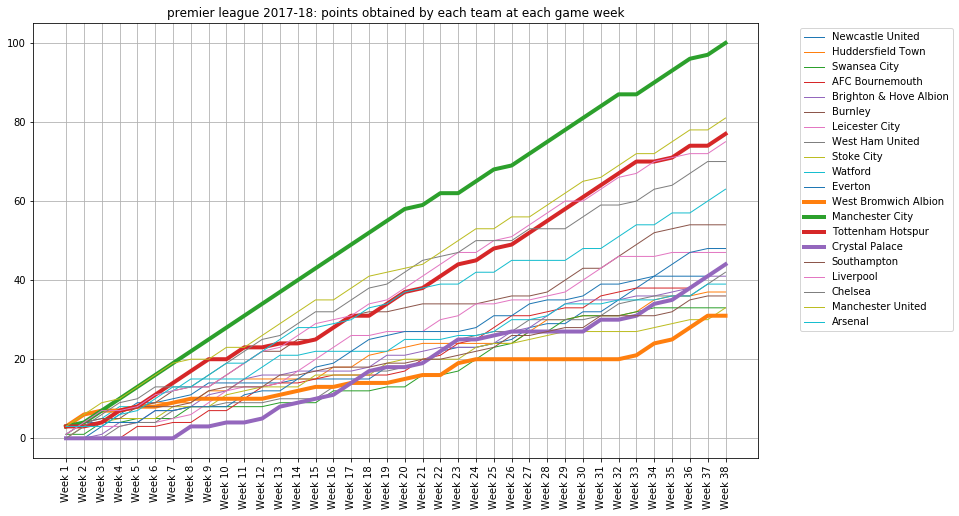

In [86]:
# Now let's plot
x = ['Week '+str(i) for i in range(1, 39)]
plt.figure(figsize=(13, 8))
for i in range(len(weeks_points)):
    lw = 1
    if names[i] in list(max_lls) or names[i] in list(max_lws): # highlight lls and lws
        lw = 4
    plt.plot(x, weeks_points[i], label = names[i], linewidth = lw)
plt.xticks(rotation = 'vertical')
plt.legend(bbox_to_anchor = (1.05, 1))
plt.title("premier league 2017-18: points obtained by each team at each game week")
plt.grid()
plt.show()
    

### RQ3 :
#### Which teams have the youngest coaches? Rank all the teams by the age of their coach and show the 10 teams with the youngest coaches. Remember that during a season a team could have more coaches, in that case pick the younger of them. Additionally, show the distirbutions of the ages of all coaches in Premier League, using a boxplot. (Hint: There's an attribute birthDate).

In [88]:
# -*- coding: utf-8 -*-
"""
Created on Tue Oct 22 11:03:32 2019

@author: antonio.furnari
"""

### ESERCIZIO 3 
### Which teams have, the youngest coaches? 
### Rank all the teams by the age of their coach and show the 10 teams 
### with the youngest coaches. Additionally, show the distirbutions of the ages 
### of all coaches in Premier League, 
### using a boxplot. (Hint: There's an attribute birthDate).

 ###homework2
#import json
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
%matplotlib inline

In [91]:
df_coaches = pd.read_json(open("data/coaches.json", "r", encoding="utf8"))
df_coaches_sort = df_coaches.sort_values(by=['birthDate'], ascending=False)
df_coaches_sort['birthDate']
df_coaches_sort.head(10)
df_teams = pd.read_json(open("data/teams.json", "r", encoding="utf8"))
area_names = df_teams.area.dropna().apply(pd.Series).name 
#extract the area names from area column
#drop the area column and assign a new column "areaName"
clean_teams = df_teams.drop('area', 1).assign(**pd.DataFrame(np.array(area_names.tolist()), columns=['areaName']))
clean_teams.head(10)
df_coaches_sort.head(10)
result = pd.merge(df_coaches_sort, clean_teams, left_on='currentTeamId', right_on='wyId')
result_filter =  result.loc[result['areaName'] == 'England']
result_filter.head(10)
result_coach_younger =  pd.DataFrame(result_filter, columns = ['name','shortName','birthDate'])
result_coach_younger.head(10)
#####################
#######ho stampato le prime dieci righe
#####################

result_coach_younger['ROWNUM'] = np.arange(len(result_coach_younger))
##result_coach_younger['Index'] = result_coach_younger.reset_index().index
result_coach_younger.head(10)


result_coach_younger['birthDate']



10    1977-11-29
11    1977-07-12
18    1973-02-19
19    1960-04-16
22    1972-03-02
23    1971-11-03
26    1971-06-28
27    1971-01-18
28    1970-05-01
37    1967-08-09
41    1967-06-16
66    1959-01-10
67    1958-12-11
72    1947-08-09
Name: birthDate, dtype: object

In [92]:
def calculateAge(birthDate): 
    today = date.today() 
    age = today.year - birthDate.year - ((today.month, today.day) < (birthDate.month, birthDate.day)) 
  
    return age 


In [94]:
calculateAge((1977-11-29), "years")

result_coach_younger.boxplot(column=['ROWNUM'], by ='birthDate')



result_coach_younger.boxplot(column=['ROWNUM'], by ='birthDate', return_type='axes', figsize=(10,10))


##########################
### OK BY NOW...BUT AFTER I TRY TO EXPLAIN BIRTH DATE AS AGE
### TO HAVE A BEST PLOT ####

result_coach_younger['birthDate'] = result_coach_younger['birthDate'].split("-")

a = raw_input().split(' ')


TypeError: calculateAge() takes 1 positional argument but 2 were given

In [95]:
def split_and_join(line):
    # write your code here
    line = line.str.split("-")
   # line  = ", ".str.join(line)
    line  = line.str.join(", ")
    return line

In [ ]:
result_coach_younger['birthDate'] = split_and_join(result_coach_younger['birthDate'])

result_coach_younger['birthDate']

AGE = calculateAge

result_coach_younger['AGE'] = calculateAge(split_and_join(result_coach_younger['birthDate']),"years")

result_coach_younger['AGE']



if __name__ == '__main__':
    line = 'a-;  -- wert'
    result = split_and_join(line)
    print(result)  

X =  pd.DataFrame(result_filter, columns = ['name'])
Y = pd.DataFrame(result_filter, columns = ['birthDate'])

plt.plot_date(x = pd.DataFrame(result_filter, columns = ['birthDate']) ,y =pd.DataFrame(result_filter, columns = ['birthDate']))
result_coach_younger

from datetime import date 
  
def calculateAge(birthDate): 
    today = date.today() 
    age = today.year - birthDate.year - ((today.month, today.day) <  (birthDate.month, birthDate.day)) 
  
    return age 
      
calculateAge(date(split_and_join(result_coach_younger['birthDate'])), "years")


np.random.seed(1234)
df = pd.DataFrame(np.random.randn(10,4), columns=['name', 'shortName', 'birthDate'])
boxplot = result_coach_younger.boxplot(column=['name', 'shortName', 'birthDate'])

# Driver code  

print(calculateAge(date(1997 - 2 - 3)), "years")
print(calculateAge(date(1997, 2, 3)), "years") 

### RQ4 :
#### Find the top 10 players with the highest ratio between completed passes and attempted passes. For this task, consider all the different types of passes, and as specified in the website, a completed pass has tag 1801 (accurate event).
#### In order to avoid meaningless results (e.g. players who played few minutes, and completed 2 passes over 2, achieving 100% ratio), select an arbitrary threshold of minimum attempted passes, in order to consider only the subset of players that played enough. Justify the choices you make.

In [38]:
events = pd.read_json("DATA/Events/events_England.json") #load events
events.drop(events[events.eventId != 8].index, inplace = True) #keep the passes and drop the rest

In [39]:
#drop useless data
events.drop(columns = ['eventSec', 'eventName', 'matchPeriod', 'subEventName', 'subEventId', 'positions'], inplace = True)

In [40]:
events = events.reset_index( drop= True ) #assign new index
# check if each pass is accurate or not and store the result in a list
is_accurate =  [any(j['id'] == 1801 for j in events.tags.values[ind]) for ind in range(len(events))]
#drop the tags column and assign a new column "isAccurate"
clean_events = events.drop('tags', 1).assign(**pd.DataFrame(np.array(is_accurate), columns=['isAccurate']))

In [41]:
treshold = 300
drop_players = []
for i in set(clean_events.playerId): #find the players with number of passes less than threshold
    if clean_events.groupby('playerId').count().loc[i].values[0] < treshold:
        drop_players += [i]
# and drop them
clean_events.drop(clean_events[clean_events.playerId.isin(drop_players)].index, inplace = True)
clean_events = clean_events.reset_index( drop= True ) #assign new index

In [42]:
#find the ratio between completed passes and attempted passes
ratio = {} 
n = 0
for i in set(clean_events.playerId):
    ratio[n] = [i, (clean_events.groupby(['playerId', 'isAccurate']).count().loc[i, True].values[0])/(clean_events.groupby('playerId').count().loc[i].values[0])]
    n += 1

In [43]:
# create a new dataframe with these valuew
finalds = pd.DataFrame.from_dict(ratio, orient = 'index', columns=['id', 'ratio'])    

In [44]:
# extract the top 10
top10 = finalds.nlargest(10, 'ratio')
# load players dataset
players = pd.read_json("DATA/players.json", encoding="utf-8")

In [45]:
# join the two dataset to find the names of top 10 players
top10 = pd.merge(top10, players[['firstName', 'lastName', 'wyId']], left_on = "id", right_on = "wyId")

In [46]:
tops = []
for i in range(len(top10)):
    # unicode sscaping to solve the unicode problem
    first_name = top10.loc[i].firstName.encode("utf-8").decode(encoding='unicode_escape')
    last_name = top10.loc[i].lastName.encode("utf-8").decode(encoding='unicode_escape')
    tops += [str(i+1) + '. ' + first_name + ' ' + last_name]
print("Top 10 players with the highest ratio between completed passes and attempted passes:")
for l in tops:
    print(l)

Top 10 players with the highest ratio between completed passes and attempted passes:
1. John Stones
2. Gnégnéri Yaya Touré
3. Fabian Delph
4. Vincent Kompany
5. Andreas Christensen
6. Phil Jones
7. Nicolás Hernán Otamendi
8. Mohamed Naser Elsayed Elneny
9. İlkay Gündoğan
10. Victor Nilsson Lindelöf


### CRQ1
#### What are the time slots of the match with more goals? Let's analyse and visualise the goals distribution into 9-minutes sets for all the matches. I.e., let's transform the minute of a goal from a continuous variable in a discrete variable (e.g. A goal scored in 5th minute, will end up in the interval [0-9)). Remind that every match goes usually from minute 0, to minute 90, but in football it is always added an arbitary amount of extra-time to every half of the match, thus consider also the intervals "45+" and "90+".

#### i.   Make a barplot with the absolute frequency of goals in all the time slots.
#### ii.  Find the top 10 teams that score the most in the interval "81-90".
#### iii. Show if there are players that were able to score at least one goal in 8 different intervals.


In [3]:
events = pd.read_json("DATA/Events/events_England.json") #load events
# check if an specific event leads to a goal or not
is_goal =  [any((j['id'] == 101) or ( j['id'] == 102) for j in events.tags.values[ind]) for ind in range(len(events))]
#drop the tags column and assign a new column "isGoal"
clean_events = events.assign(**pd.DataFrame(np.array(is_goal), columns=['isGoal']))

In [4]:
# by looking at the data, we can see that for each goal, there have been 2 records stored in the dataset!
# first one with label shot, free kick or sth like this and tags 101 and 1801 which is an accurate shot and leads to the goal
# the other one with label save attemp and tags 101 and 1802 which is a failed save and leads to a goal for opponent
# again by looking at the matches and events dataset we can realize that for every own goal, there have been 2 records stored in the dataset!
# first one with a 102 tag (which can come alongside a 1801 or not!) that leads to a goal for opponent
# second one a save attemp with tags 101 and 1802 which is a failed save and leads to a goal again for opponent

# however there are some mistakes in the datasets
# for example for matchId = 2499781 which refers to Chelsea - Manchester City September 30, 2017 
# an event with label "save attemp" and tags 101 and 1802 has been stored which refers to Courtois's fail in saving the goal
# but there is no other record stored with tag 101 or 102, as kevin de bruyne's shot!
# if we separate save attemps from other records eith tags 101 and 102 (I mean the real goals):
# there are 1021 "save attemp"s and 1015 of the others...
# I prefer to use 1015 records and forget about the 3 missed ones



# lets drop each record that is not a goal
clean_events.drop(clean_events[clean_events.isGoal == False].index, inplace = True)
# agian drop the useless data
clean_events.drop( columns = ['isGoal', 'positions', 'subEventId', 'eventId'], inplace = True)
clean_events = clean_events.reset_index( drop= True ) #assign new index

In [5]:
# now we can extract save attemps which are records with both 101 and 1802 tags
save_attemp = [(any(j['id'] == 101 for j in clean_events.tags.values[ind]) and any(j['id'] == 1802 for j in clean_events.tags.values[ind])) for ind in range(len(clean_events))]
clean_events = clean_events.assign(**pd.DataFrame(np.array(save_attemp), columns=['saveAttemp']))
# and drop them
clean_events.drop(clean_events[clean_events.saveAttemp == True].index, inplace = True)
clean_events = clean_events.reset_index( drop= True ) #assign new index

In [6]:
intervals = []
for ind in range(len(clean_events)):
    minute = clean_events.eventSec[ind]/540
    if clean_events.matchPeriod[ind] == '1H': # in which interval the goal was scored
        if minute <= 1:
            intervals += [1]
        elif minute <= 2:
            intervals += [2]
        elif minute <= 3:
            intervals += [3]
        elif minute <= 4:
            intervals += [4]
        elif minute <= 5:
            intervals += [5]
        else:
            intervals += [6]
    elif clean_events.matchPeriod[ind] == '2H':
        if minute <= 1:
            intervals += [7]
        elif minute <= 2:
            intervals += [8]
        elif minute <= 3:
            intervals += [9]
        elif minute <= 4:
            intervals += [10]
        elif minute <= 5:
            intervals += [11]
        else:
            intervals += [12]
clean_events = clean_events.drop(columns = ['saveAttemp']).assign(**pd.DataFrame(np.array(intervals), columns=['interval']))

<function matplotlib.pyplot.show(*args, **kw)>

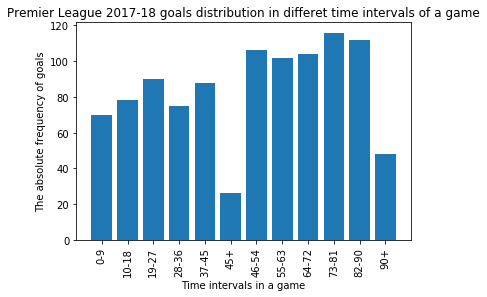

In [7]:
height = clean_events.groupby('interval').count().id.values # count the goals in each interval
plt.bar(['0-9', '10-18', '19-27', '28-36', '37-45', '45+', '46-54', '55-63', '64-72', '73-81', '82-90', '90+'], height)
plt.xticks(rotation = 'vertical')
plt.title("Premier League 2017-18 goals distribution in differet time intervals of a game")
plt.ylabel('The absolute frequency of goals')
plt.xlabel('Time intervals in a game')
plt.show

In [8]:
interval81_90 = clean_events.drop(clean_events[clean_events.interval != 11].index) # extract the goals scored in interval 81-90
top10 = interval81_90.groupby('teamId').count().nlargest(10, 'id') # find the top10 teams
# load teams dataset
teams = pd.read_json("DATA/teams.json", encoding="utf-8")
# join the two dataset to find the names of top 10 teams
top10 = pd.merge(top10, teams[['name', 'wyId']], left_on = "teamId", right_on = "wyId")

In [10]:
tops = []
for i in range(len(top10)):
    tops += [str(i+1) + '. ' + str(top10.name.loc[i])]
print("Top 10 teams that score the most in the interval '81-90':")
for l in tops:
    print(l)

Top 10 teams that score the most in the interval '81-90':
1. Manchester City
2. Arsenal
3. Chelsea
4. Manchester United
5. Liverpool
6. Crystal Palace
7. Watford
8. West Ham United
9. Tottenham Hotspur
10. West Bromwich Albion


In [35]:
res = []
for p in set(clean_events.playerId): #for each player
    p_goals = clean_events.drop(clean_events[clean_events.playerId != p].index)
    p_intervals = set()
    for ind in p_goals.index: #store the interval this player managed to score at least one
        p_intervals.add(p_goals.interval.loc[ind])
    if(len(p_intervals) > 7): #check if there are 8 intervals or more
        res += [p]

In [36]:
# load players dataset
players = pd.read_json("DATA/players.json", encoding="utf-8")
print("Players that were able to score at least one goal in 8 different intervals: ")
for i in res: # find the names related to playerIds
    first_name = players[players.wyId == i].firstName.values[0].encode("utf-8").decode(encoding='unicode_escape')
    last_name = last_name = players[players.wyId == i].lastName.values[0].encode("utf-8").decode(encoding='unicode_escape')
    print("- " + first_name + " " + last_name)

Players that were able to score at least one goal in 8 different intervals: 
- Harry Kane
- Jamie Vardy
- Mohamed  Salah Ghaly
- Riyad Mahrez
- Romelu Lukaku Menama
- Wilfried Zaha
- Álvaro Borja Morata Martín
- Raheem Shaquille Sterling
- Alexandre Lacazette
- Marko Arnautović
- Gabriel Fernando de Jesus
- Roberto Firmino Barbosa de Oliveira
